In [1]:
pip install -U kaleido

Note: you may need to restart the kernel to use updated packages.


## Required Imports

In [2]:
import numpy as np
import tensorflow as tf
import gc, sys, glob
import os
from tensorflow.keras import Input
from tensorflow.keras import models as M
from tensorflow.keras import layers as L
from tensorflow.keras import backend as keras
from tensorflow.keras.utils import plot_model
import trimesh
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import fpsample
from transformers import TFBertModel, BertTokenizer
import tensorflow_graphics as tfg
from tensorflow_graphics.nn.loss import chamfer_distance
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from concurrent.futures import ThreadPoolExecutor
from urllib.parse import urlparse, parse_qs
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import socket
import json
import subprocess
import plotly.graph_objects as go


2024-11-04 03:31:24.680923: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-04 03:31:24.680987: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-04 03:31:24.682302: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-04 03:31:24.689512: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/projects/envs/conda/ayassin/envs/t

# Utility Functions for the model 

In [3]:
def pairwise_distance(xyz1, xyz2):
    n = xyz1.shape[1]
    c = xyz1.shape[2]
    m = xyz2.shape[1]
    xyz1 = tf.tile(tf.reshape(xyz1, (-1,1,n,c)), [1,m,1,1])
    xyz2 = tf.tile(tf.reshape(xyz2, (-1,m,1,c)), [1,1,n,1])
    dist = tf.reduce_sum((xyz1-xyz2)**2, -1)
    return dist

def knn_point(k, xyz1, xyz2):
    dist = -pairwise_distance(xyz1, xyz2)
    val, idx = tf.math.top_k(dist, k)
    return -val, idx

class UniformSampler(tf.keras.layers.Layer):
    def __init__(self, num_points, seed=42, **kwargs):
        super(UniformSampler, self).__init__(**kwargs)
        self.num_points = num_points
        self.seed = seed

    def build(self, input_shape):
        pass

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        data_size = tf.shape(inputs)[1]
        indices = tf.random.uniform(
            shape=(batch_size, self.num_points),
            minval=0,
            maxval=data_size,
            dtype=tf.int32,
            seed=self.seed
        )
        return indices

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.num_points, input_shape[2])

    def get_config(self):
        config = super(UniformSampler, self).get_config()
        config.update({
            "num_points": self.num_points,
            "seed": self.seed
        })
        return config

def sample_and_group(args, nsample):
    xyz, pts, fps_idx = args
    new_xyz = tf.gather_nd(xyz, tf.expand_dims(fps_idx,-1), batch_dims=1)
    new_pts = tf.gather_nd(pts, tf.expand_dims(fps_idx,-1), batch_dims=1)
    _, idx = knn_point(nsample, xyz, new_xyz)
    grouped_pts = tf.gather_nd(pts, tf.expand_dims(idx,-1), batch_dims=1)
    grouped_pts -= tf.tile(tf.expand_dims(new_pts, 2),
                           (1,1,nsample,1))
    new_pts = tf.concat([grouped_pts,
                         tf.tile(tf.expand_dims(new_pts, 2),
                                 (1,1,nsample,1))],
                        axis=-1)
    return new_xyz, new_pts

def LBR(tensor, C, seq_name, use_bias=True, activation=None, LeakyAlpha=0.0):
    x_in = Input(shape=tensor.shape[1:], name=seq_name+'_input')
    x = L.Dense(C, use_bias=use_bias, activation=activation, name=seq_name+'_lin')(x_in)
    if LeakyAlpha==0.0:
        x_out = L.ReLU(name=seq_name+'_ReLU')(x)
    else:
        x_out = L.LeakyReLU(alpha=LeakyAlpha, name=seq_name+'_ReLU')(x)
    model = M.Model(inputs=x_in, outputs=x_out, name=seq_name)
    return model(tensor)

def Self_Attention(tensor, seq_name):
    x_in = Input(shape=tensor.shape[1:], name=seq_name+'_input')
    C = x_in.shape[2]
    W_q = L.Dense(C//4, use_bias=False, activation=None, name=seq_name+'_Q')
    W_k = L.Dense(C//4, use_bias=False, activation=None, name=seq_name+'_K')
    W_v = L.Dense(C, use_bias=False, activation=None, name=seq_name+'_V')
    x_q = W_q(x_in)
    x_k = W_k(x_in)
    W_k.set_weights(W_q.get_weights())
    x_k = L.Lambda(lambda t: tf.transpose(t, perm=(0,2,1)), name=seq_name+'_KT')(x_k)
    x_v = W_v(x_in)
    energy = L.Lambda(lambda ts: tf.matmul(ts[0],ts[1]), name=seq_name+'_matmul1')([x_q, x_k])
    attention = L.Softmax(axis=1, name=seq_name+'_softmax')(energy)
    attention = L.Lambda(lambda t: t / (1e-9 + tf.reduce_sum(t, axis=2, keepdims=True)), name=seq_name+'_l1norm')(attention)
    x_r = L.Lambda(lambda ts: tf.matmul(ts[0],ts[1]), name=seq_name+'_matmul2')([attention, x_v])
    x_r = L.Lambda(lambda ts: tf.subtract(ts[0],ts[1]), name=seq_name+'_subtract')([x_in, x_r])
    x_r = LBR(x_r, C, seq_name+'_LBR', use_bias=True)
    x_out = L.Lambda(lambda ts: tf.add(ts[0],ts[1]), name=seq_name+'_add')([x_in, x_r])
    model = M.Model(inputs=x_in, outputs=x_out, name=seq_name)
    return model(tensor)


def Cross_Attention(args, seq_name):
    E_tensor, D_tensor = args
    xE_in = Input(shape=E_tensor.shape[1:], name=seq_name+'_input-E')
    C = xE_in.shape[2]
    xD_in = Input(shape=D_tensor.shape[1:], name=seq_name+'_input-D')
    out_dim = xD_in.shape[2]
    W_q = L.Dense(C//4, use_bias=False, activation=None, name=seq_name+'_Q')
    W_k = L.Dense(C//4, use_bias=False, activation=None, name=seq_name+'_K')
    W_v = L.Dense(out_dim, use_bias=False, activation=None, name=seq_name+'_V')
    x_q = W_q(xD_in)
    x_k = W_k(xE_in)
    x_k = L.Lambda(lambda t: tf.transpose(t, perm=(0,2,1)), name=seq_name+'_KT')(x_k)
    x_v = W_v(xE_in)
    energy = L.Lambda(lambda ts: tf.matmul(ts[0],ts[1]), name=seq_name+'_matmul1')([x_q, x_k])
    attention = L.Softmax(axis=1, name=seq_name+'_softmax')(energy)
    attention = L.Lambda(lambda t: t / (1e-9 + tf.reduce_sum(t, axis=2, keepdims=True)), name=seq_name+'_l1norm')(attention)
    x_r = L.Lambda(lambda ts: tf.matmul(ts[0],ts[1]), name=seq_name+'_matmul2')([attention, x_v])
    x_r = L.Lambda(lambda ts: tf.subtract(ts[0],ts[1]), name=seq_name+'_subtract')([xD_in, x_r])
    x_r = LBR(x_r, out_dim, seq_name+'_LBR', use_bias=True)
    x_out = L.Lambda(lambda ts: tf.add(ts[0],ts[1]), name=seq_name+'_add')([xD_in, x_r])
    model = M.Model(inputs=[xE_in,xD_in], outputs=x_out, name=seq_name)
    return model([E_tensor,D_tensor])

def copy_and_mapping(tensor, nmul, seq_name):
    x_in = Input(shape=tensor.shape[1:], name=seq_name+'_input')
    x = L.Lambda(lambda t: tf.expand_dims(t, 2), name=seq_name+'_expand')(x_in)
    C = x.shape[-1]//nmul
    x1 = L.Conv2DTranspose(C,(1,nmul),(1,nmul), use_bias=True, activation=None, name=seq_name+'_convT')(x)
    x2 = L.Dense(C, use_bias=True, activation=None, name=seq_name+'_lin')(x)
    x2 = L.Lambda(lambda t: tf.tile(t, [1,1,nmul,1]), name=seq_name+'_tile')(x2)
    x = L.Lambda(lambda ts: tf.add(ts[0],ts[1]), name=seq_name+'_add')([x1, x2])
    npoint = x.shape[1]*x.shape[2]
    x_out = L.Lambda(lambda t: tf.reshape(t, [-1,npoint,t.shape[3]]), name=seq_name+'_reshape')(x)
    model = M.Model(inputs=x_in, outputs=x_out, name=seq_name)
    return model(tensor)

## Point Encoder

In [4]:
def PCT_encoder(xyz):
    x = LBR(xyz, 64, 'E-IN_LBR1', use_bias=False)
    x = LBR(x, 128, 'E-IN_LBR2', use_bias=False)
    fps_idx = UniformSampler(4096)(xyz)
    new_xyz, new_feature = L.Lambda(sample_and_group, arguments={'nsample':32}, name='E-SG1')([xyz, x, fps_idx])
    x = LBR(new_feature, 512, 'E-SG1_LBR1', use_bias=False)
    x = L.Lambda(lambda t: tf.reduce_max(t, axis=2), name='E-SG1_MaxPool')(x)
    fps_idx = UniformSampler(2048)(new_xyz)
    new_xyz, new_feature = L.Lambda(sample_and_group, arguments={'nsample':32}, name='E-SG2')([new_xyz, x, fps_idx])
    x = LBR(new_feature, 1024, 'E-SG2_LBR1', use_bias=False)
    x = L.Lambda(lambda t: tf.reduce_max(t, axis=2), name='E-SG2_MaxPool')(x)
    x1 = Self_Attention(x, 'E-SA1')
    x2 = Self_Attention(x1, 'E-SA2')
    x3 = Self_Attention(x2, 'E-SA3')
    x4 = Self_Attention(x3, 'E-SA4')
    x0 = L.Lambda(lambda ts: tf.concat(ts, axis=2), name='E-SA_Concat')([x1,x2,x3,x4])
    x = L.Lambda(lambda ts: tf.concat(ts, axis=2), name='E-OUT_Concat')([x0,x])
    x = LBR(x, 2048, 'E-OUT_LBR', use_bias=False, LeakyAlpha=0.2)
    x1 = Self_Attention(x, 'E-SA5')
    x2 = Self_Attention(x1, 'E-SA6')
    x3 = Self_Attention(x2, 'E-SA7')
    x4 = Self_Attention(x3, 'E-SA8')
    x0 = L.Lambda(lambda ts: tf.concat(ts, axis=2), name='E-SA_Concat2')([x1,x2,x3,x4])
    x = LBR(x0, 4096, 'E-OUT_LBR1', use_bias=False, LeakyAlpha=0.2)
    output_feats = L.Lambda(lambda t: tf.reduce_max(t, axis=1, keepdims=True), name='E-OUT_MaxPool')(x)
    return output_feats

## Point Decoder

In [5]:
def pct_decoder(input_feats, input_eye_seed):
    m_feats = L.Lambda(lambda x: tf.tile(x, [1,1024,1]), name = 'D-IN_replicate')(input_feats)
    input_eye = input_eye_seed + tf.eye(1024,1024)
    x = L.Dense(4096//4, use_bias=False, activation=None, name='D1-IN')(input_eye)
    x1 = Cross_Attention([m_feats,x] , 'D-STA1')
    x2 = Cross_Attention([m_feats,x1], 'D-STA2')
    x3 = Cross_Attention([m_feats,x2], 'D-STA3')
    x4 = Cross_Attention([m_feats,x3], 'D-STA4')
    x0 = L.Lambda(lambda ts: tf.concat(ts, axis=2), name='D1-STA_Concat')([x1,x2,x3,x4])
    x = L.Lambda(lambda ts: tf.concat(ts, axis=2), name='D1-OUT_Concat')([x0,x])
    m_feats2 = copy_and_mapping(x, 3, 'D1-OUT_CopyAndMapping')
    input_eye2 = input_eye_seed + tf.eye(3072,3072)
    x = L.Dense(1024//4, use_bias=False, activation=None, name='D2-IN')(input_eye2)
    x1 = Cross_Attention([m_feats2,x] , 'D2-STA1')
    x2 = Cross_Attention([m_feats2,x1], 'D2-STA2')
    x3 = Cross_Attention([m_feats2,x2], 'D2-STA3')
    x4 = Cross_Attention([m_feats2,x3], 'D2-STA4')
    x0 = L.Lambda(lambda ts: tf.concat(ts, axis=2), name='D2-STA_Concat')([x1,x2,x3,x4])
    x = L.Lambda(lambda ts: tf.concat(ts, axis=2), name='D2-OUT_Concat')([x0,x])
    x = copy_and_mapping(x, 2, 'D2-OUT_CopyAndMapping')
    x = LBR(x,128, 'D-OUT_LBR1', use_bias=False)
    x = LBR(x,128, 'D-OUT_LBR2', use_bias=False)
    x = LBR(x, 64, 'D-OUT_LBR3', use_bias=False, LeakyAlpha=0.2)
    output_points = L.Dense(3, activation=None, name='D-OUT_lin')(x)
    return output_points

## Bert Text Encoder

In [6]:
def bert_model(input_ids, attention_mask, model_name='bert-base-uncased', max_length=128):
    bert_model = TFBertModel.from_pretrained(model_name)
    bert_model.trainable = False
    bert_outputs = bert_model([input_ids, attention_mask])
    cls_output = bert_outputs.pooler_output
    dense_output = tf.keras.layers.Dense(4096, activation='relu')(cls_output)
    output = tf.expand_dims(dense_output, axis = 1)
    return output

## Building the multi-modal point cloud autoencoder

In [7]:
class PCT_AE_Multimodal:
    def __init__(self, num_input_points=4096, max_length=128, bert_model=bert_model, PCT_encoder=PCT_encoder, pct_decoder=pct_decoder):
        self.num_input_points = num_input_points
        self.max_length = max_length
        self.bert_model = bert_model
        self.PCT_encoder = PCT_encoder
        self.pct_decoder = pct_decoder
        self.model = self.build_model()

    def build_model(self):
        eye_seed = Input(shape=(1, 1), name='input_eye_seed')
        xyz = Input(shape=(self.num_input_points, 3), name='input_points')
        input_ids = Input(shape=(self.max_length,), dtype=tf.int32, name='input_ids')
        attention_mask = Input(shape=(self.max_length,), dtype=tf.int32, name='attention_mask')
        if not self.bert_model or not self.PCT_encoder or not self.pct_decoder:
            raise ValueError("Bert model, PCT encoder, and PCT decoder must be provided.")
        text_encoded = self.bert_model(input_ids, attention_mask)
        cloud_encoded = self.PCT_encoder(xyz)
        multi_encoded = cloud_encoded + text_encoded
        output = self.pct_decoder(multi_encoded, eye_seed)
        return M.Model(inputs=[xyz, eye_seed, input_ids, attention_mask], outputs=output)

# Inference Function

### Example Usage of `run_inference`

To run inference with a single `.ply` file and class name:
```python
ply_file_path = 'path/to/cloud.ply'
class_name = 'example_class'
output = run_inference(AE, ply_file_path, class_name)
```
To run inference with a single NumPy array and class name:
```python
sample_point_cloud = np.random.rand(4096, 3)  # Example point cloud
class_name = 'example_class'
output = run_inference(AE, sample_point_cloud, class_name)
```
To run inference with multiple point clouds and class names:
```python
point_clouds = ['path/to/cloud1.ply', np.random.rand(4096, 3)]
class_names = ['class1', 'class2']
output = run_inference(AE, point_clouds, class_names)
```


In [8]:
def normalize_point_cloud(point_cloud):
    mean = np.mean(point_cloud, axis=0)
    point_cloud -= mean
    max_distance = np.max(np.sqrt(np.sum(point_cloud ** 2, axis=1)))
    point_cloud /= max_distance
    return point_cloud

def run_inference(model, point_cloud_input, class_name):
    """
    Runs inference using a provided model with a single or batch of point clouds and corresponding class names.
    The point clouds can be provided as file paths, NumPy arrays, or TensorFlow tensors.

    Args:
        model: The model to be used for inference.
        point_cloud_input (str, np.array, tf.Tensor, or list): A single PLY file path, 2D NumPy array,
                                                               TensorFlow tensor, or a list of these.
        class_name (str or list): A single class name or a list of class names, one for each point cloud.
    
    Returns:
        The output from the model.
    """
    # Ensure point_cloud_input and class_name are lists for batch processing
    if not isinstance(point_cloud_input, list):
        point_cloud_input = [point_cloud_input]
    if not isinstance(class_name, list):
        class_name = [class_name]

    if len(point_cloud_input) != len(class_name):
        raise ValueError("The number of point clouds must match the number of class names.")

    # Initialize lists to hold processed point clouds and tokenized text
    processed_point_clouds = []
    input_ids_list = []
    attention_mask_list = []

    # Initialize BERT tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Process each point cloud and class name
    for pc_input, cls_name in zip(point_cloud_input, class_name):
        # Check the type of the point cloud input and process accordingly
        if isinstance(pc_input, str):
            # Load the point cloud from the .ply file using trimesh
            mesh = trimesh.load_mesh(pc_input, file_type='ply')
            point_cloud = np.array(mesh.vertices)
        elif isinstance(pc_input, np.ndarray):
            point_cloud = pc_input
        elif isinstance(pc_input, tf.Tensor):
            point_cloud = pc_input.numpy()
        else:
            raise TypeError("Each point cloud input should be a file path (str), a 2D NumPy array, or a TensorFlow tensor.")

        # Check that the point cloud has the correct shape
        if point_cloud.ndim != 2 or point_cloud.shape[1] != 3:
            raise ValueError("Each point cloud should be of shape (N, 3), where N is the number of points.")

        # Normalize the point cloud
        point_cloud = normalize_point_cloud(point_cloud)

        # Sample points using farthest point sampling
        partial_indices = fpsample.fps_sampling(point_cloud, 4096, start_idx=0)
        sampled_cloud = point_cloud[partial_indices]
        processed_point_clouds.append(sampled_cloud)

        # Tokenize the class name using BERT
        encoded_text = tokenizer.encode_plus(
            cls_name,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_tensors='tf'
        )
        input_ids_list.append(encoded_text['input_ids'])
        attention_mask_list.append(encoded_text['attention_mask'])

    # Convert lists to tensors
    sample_point_clouds = tf.convert_to_tensor(processed_point_clouds, dtype=tf.float32)
    input_ids = tf.concat(input_ids_list, axis=0)
    attention_mask = tf.concat(attention_mask_list, axis=0)
    eye_seed = tf.zeros([len(point_cloud_input), 1, 1], dtype=tf.float32)

    # Call the model
    output = model([sample_point_clouds, eye_seed, input_ids, attention_mask])

    return output

## Visualization function

In [9]:

def visualize_cloud(point_cloud, title="Point Cloud Visualization"):
    """
    Visualizes a 3D point cloud using Plotly. The input can be a .ply file, a 2D/3D NumPy array,
    or a 2D/3D TensorFlow tensor.

    Args:
        point_cloud (str, np.array, or tf.Tensor): Path to a .ply file or a 2D/3D NumPy array or
                                                   TensorFlow tensor of shape (N, 3) or (1, N, 3),
                                                   where N is the number of points.
        title (str): Title of the plot.
    """
    # Check if the input is a string (assume it's a file path)
    if isinstance(point_cloud, str):
        # Load the point cloud from the .ply file using trimesh
        mesh = trimesh.load_mesh(point_cloud, file_type='ply')
        point_cloud = np.array(mesh.vertices)
    elif isinstance(point_cloud, (np.ndarray, tf.Tensor)):
        # Convert TensorFlow tensor to NumPy array if needed
        if isinstance(point_cloud, tf.Tensor):
            point_cloud = point_cloud.numpy()
        
        # Handle the case where point_cloud has a batch dimension
        if point_cloud.ndim == 3:
            if point_cloud.shape[0] > 1:
                raise ValueError("Only one point cloud can be visualized at a time. Please provide a single point cloud.")
            elif point_cloud.shape[0] == 1:
                # Discard the batch dimension
                point_cloud = point_cloud[0]
        elif point_cloud.ndim != 2 or point_cloud.shape[1] != 3:
            raise ValueError("Point cloud should be of shape (N, 3) or (1, N, 3), where N is the number of points.")
    else:
        raise TypeError("point_cloud should be a file path (str), a 2D/3D NumPy array, or a TensorFlow tensor.")

    # Extract x, y, and z coordinates
    x, y, z = point_cloud[:, 0], point_cloud[:, 1], point_cloud[:, 2]

    # Create a 3D scatter plot using Plotly
    fig = go.Figure(
        data=[
            go.Scatter3d(
                x=x,
                y=y,
                z=z,
                mode='markers',
                marker=dict(
                    size=2,  # Size of the markers
                    color=z,  # Use the z-values for color
                    colorscale='Viridis',  # Color scale
                    opacity=0.8
                )
            )
        ]
    )

    # Set the layout of the plot
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title='X Axis',
            yaxis_title='Y Axis',
            zaxis_title='Z Axis'
        ),
        margin=dict(l=0, r=0, b=0, t=40)
    )

    fig.show()

# We now can use the model

## Instantiating the model

In [10]:
AE = PCT_AE_Multimodal(bert_model=bert_model, PCT_encoder=PCT_encoder, pct_decoder=pct_decoder)
AE = AE.model

2024-11-04 03:31:31.073475: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46871 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassificat

## Loading the Weights

In [11]:
AE.load_weights("MSN_checkpoint2/MSN_weights3.h5")

## Running inference on a partial point cloud 

In [22]:

partial_path = "github_demo_data/demo_point_clouds/incomplete/spleen_incomplete.ply"
output = run_inference(AE, partial_path, class_name= 'spleen')


## Visualizing the results

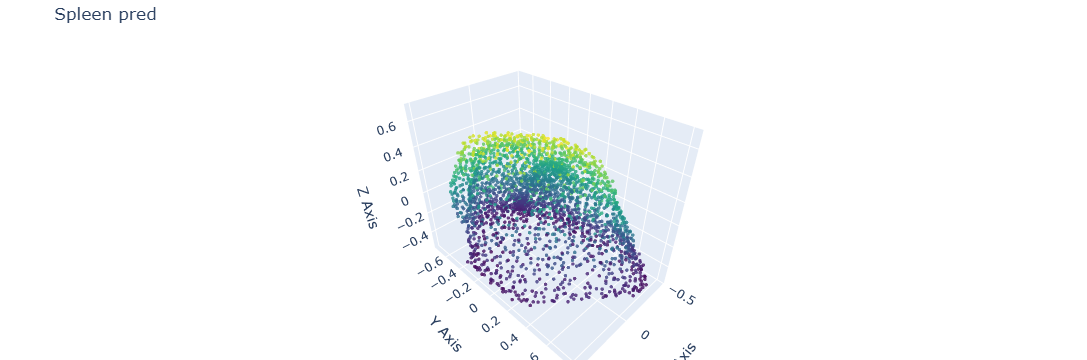

In [27]:

visualize_cloud(output, title = "Spleen pred")


In [28]:
visualize_cloud(partial_path, title = "Spleen partial input")

In [29]:
visualize_cloud("github_demo_data/demo_point_clouds/complete/spleen_complete.ply", title = "Spleen GT")